# Riiid Project
### Personalized Digital Education

<strong>Darden Capstone Project
***

# Table of Contents <a id='toc'></a>
1. [Acquire](#acquire)
2. [Prepare](#prepare)
3. [Explore](#explore)
4. [Modeling](#modeling)
5. [Conclusions](#conclusions)

## About Riiid Labs

Riiid Labs, an AI solutions provider delivering creative disruption to the education market. With a strong belief in equal opportunity in education, Riiid launched an AI tutor based on deep-learning algorithms in 2017 that attracted more than one million South Korean students. This year, the company released EdNet, the world’s largest open database for AI education containing more than 100 million student interactions. [Source](https://www.kaggle.com/c/riiid-test-answer-prediction/overview/description)

## Our Goal

This project aims to create a machine learning model that can predict whether or not a user will answer a question correctly using data provided by Riiid Labs.

# Imports

In [1]:
# General Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
%matplotlib inline

# Acquire and Prepare Files
import acquire, prepare, explore, model
from explore import rfe_ranker
from model import train_model, validate_model, auc_score_proba

# Modeling Modules
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Warnings 
import warnings
warnings.filterwarnings("ignore")

# Create A Progressive Bar for Loop Operation 
from tqdm.notebook import tqdm

# 1. Acquire<a id='acquire'></a>
Acquire the data used for this project. 

[Return to Top](#toc)
***

In [2]:
%%time
# Compute the time to run this cell

# Define the data types
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16", 
    "content_type_id": "boolean", 
    "task_container_id": "int16",
    "user_answer": "int8", 
    "answered_correctly": "int8", 
    "prior_question_elapsed_time": "float32"   
}

# Reading in data from local files
df_train = pd.read_csv('sampled_trainset.csv', dtype=dtypes)
df_validate = pd.read_csv('validate.csv', dtype=dtypes)
df_test = pd.read_csv('test.csv', dtype=dtypes)

df_train.shape, df_validate.shape, df_test.shape

CPU times: user 51.3 s, sys: 4.81 s, total: 56.2 s
Wall time: 56.8 s


((20964878, 18), (2590034, 18), (2693188, 18))

In [3]:
# Train Data
df_train.head(2)

timestamp  user_id  content_id  content_type_id  task_container_id  \
0          0    24600        7900            False                  0   
1      25379    24600        7876            False                  1   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            0                   1                          NaN   
1            2                   0                      24000.0   

  prior_question_had_explanation  lecture_id  tag  lecture_part type_of  \
0                            NaN         NaN  NaN           NaN     NaN   
1                          False         NaN  NaN           NaN     NaN   

   question_id  bundle_id  correct_answer  question_part       tags  
0       7900.0     7900.0             0.0            1.0  131 93 81  
1       7876.0     7876.0             3.0            1.0   10 94 92

In [4]:
# Validate Data
df_validate.head(2)

timestamp  user_id  content_id  content_type_id  task_container_id  \
0    1326986    24600         646            False                 26   
1    1353977    24600        1067            False                 27   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            3                   1                      29000.0   
1            1                   1                      30000.0   

   prior_question_had_explanation  lecture_id  tag  lecture_part type_of  \
0                            True         NaN  NaN           NaN     NaN   
1                            True         NaN  NaN           NaN     NaN   

   question_id  bundle_id  correct_answer  question_part                tags  
0        646.0      646.0             3.0            2.0      69 17 56 81 92  
1       1067.0     1067.0             1.0            2.0  129 2 56 162 38 92

In [5]:
# Test Data
df_test.head(2)

timestamp  user_id  content_id  content_type_id  task_container_id  \
0    1453702    24600        1262            False                 31   
1    1477283    24600        1348            False                 32   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            0                   0                      16000.0   
1            3                   1                      19000.0   

   prior_question_had_explanation  lecture_id  tag  lecture_part type_of  \
0                            True         NaN  NaN           NaN     NaN   
1                            True         NaN  NaN           NaN     NaN   

   question_id  bundle_id  correct_answer  question_part           tags  
0       1262.0     1262.0             1.0            2.0   143 71 81 29  
1       1348.0     1348.0             3.0            2.0  143 105 81 92

### Acquire Takeaways
- Data acquired from Kaggle: lectures.csv, questions.csv, and train.csv.
- Created a function to create a merged csv file of train, lectures, and questions.
- Converted the data types of numeric columns to reduce memory usage.
- Created a function to select a random sample of 100K users.
- Created a function to split the merged dataset into train, validate, and test.
    - 80% of a users data in train, 10% in validate, and 10% in test.

# 2. Prepare<a id='prepare'></a>
Prepare the data for exploration and created scaled features for modeling.<br>

[Return to Top](#toc)
***

### Run Prepare Function (found in prepare.py module)

In [6]:
%%time
# Compute time to run this cell

# Produce train/validate/test and scaled train/validate/test dataframes
train, validate, test, train_s, validate_s, test_s = prepare.prep_riiid(df_train, df_validate, df_test)

CPU times: user 3min 48s, sys: 1min 10s, total: 4min 59s
Wall time: 5min 2s


In [7]:
# RUN THIS CELL WHEN NECESSARY
# Run this cell if only the dtype of user_lectures_running_total is object

train.user_lectures_running_total = train.user_lectures_running_total.apply(lambda i: 0 if i == 'False' else i)
train.user_lectures_running_total = train.user_lectures_running_total.astype('int32')

In [8]:
# Print the shape of train
print(train.shape)

# Display first 5 rows of train
train.head()

(20554519, 21)


timestamp  user_id  content_id  task_container_id  answered_correctly  \
0          0    24600        7900                  0                   1   
1      25379    24600        7876                  1                   0   
2      50137    24600         175                  2                   1   
3          0   128919        7900                  0                   1   
4      22862   128919        7876                  1                   0   

  question_had_explanation  user_acc_mean  user_lectures_running_total  \
0                    False       0.275000                            0   
1                    False       0.275000                            0   
2                    False       0.275000                            0   
3                    False       0.333333                            0   
4                    False       0.333333                            0   

    q_time  avg_user_q_time  ...  bundle_id  part       tags tag_count  \
0  25379.0          70525.0  ...       7900     1  131 93 81         3   
1  24758.0          70525.0  ...       7876     1   10 94 92         3   
2  20044.0          70525.0  ...        175     1    9 10 92         3   
3  22862.0          60393.0  ...       7900     1  131 93 81         3   
4  24620.0          60393.0  ...       7876     1   10 94 92         3   

   mean_bundle_accuracy  mean_part_accuracy  mean_content_accuracy  \
0                  0.82                0.74                   0.82   
1                  0.41                0.74                   0.41   
2                  0.36                0.74                   0.36   
3                  0.82                0.74                   0.82   
4                  0.41                0.74                   0.41   

   mean_task_accuracy  mean_tagcount_accuracy  mean_tags_accuracy  
0                0.68                0.675394            0.777457  
1                0.53                0.675394            0.492395  
2                0.44                0.675394            0.524273  
3                0.68                0.675394            0.777457  
4                0.53                0.675394            0.492395  

[5 rows x 21 columns]

In [9]:
# Print the shape of train scaled
print(train_s.shape)

# Display first 5 rows of train scaled 
train_s.head()

(20554519, 11)


answered_correctly  question_had_explanation  user_acc_mean  \
0                   1                         0       0.275000   
1                   0                         0       0.275000   
2                   1                         0       0.275000   
3                   1                         0       0.333333   
4                   0                         0       0.333333   

   mean_bundle_accuracy  mean_part_accuracy  mean_content_accuracy  \
0                  0.82                0.74                   0.82   
1                  0.41                0.74                   0.41   
2                  0.36                0.74                   0.36   
3                  0.82                0.74                   0.82   
4                  0.41                0.74                   0.41   

   mean_task_accuracy  mean_tagcount_accuracy  mean_tags_accuracy  \
0                0.68                0.675394            0.777457   
1                0.53                0.675394            0.492395   
2                0.44                0.675394            0.524273   
3                0.68                0.675394            0.777457   
4                0.53                0.675394            0.492395   

   user_lectures_running_total_scaled  avg_user_q_time_scaled  
0                                 0.0                0.000003  
1                                 0.0                0.000003  
2                                 0.0                0.000003  
3                                 0.0                0.000003  
4                                 0.0                0.000003

In [10]:
# Print the shape of validate 
print(validate.shape)

# Display first 5 rows of validate
validate.head()

(2540985, 20)


timestamp  user_id  content_id  task_container_id  answered_correctly  \
0    1326986    24600         646                 26                   1   
1    1353977    24600        1067                 27                   1   
2    1377689    24600         940                 28                   0   
3    1403698    24600       10685                 29                   1   
4    1426174    24600         817                 30                   1   

  question_had_explanation  user_acc_mean user_lectures_running_total  \
0                     True          0.275                       False   
1                     True          0.275                           0   
2                     True          0.275                           0   
3                     True          0.275                           0   
4                     True          0.275                           0   

   avg_user_q_time  question_id  bundle_id  part                tags  \
0          70525.0          646        646     2      69 17 56 81 92   
1          70525.0         1067       1067     2  129 2 56 162 38 92   
2          70525.0          940        940     2        143 20 38 29   
3          70525.0        10685      10685     2    69 137 142 38 29   
4          70525.0          817        817     2         17 56 38 29   

   tag_count  mean_bundle_accuracy  mean_part_accuracy  mean_content_accuracy  \
0          5                  0.80                0.71                   0.80   
1          6                  0.91                0.71                   0.91   
2          4                  0.90                0.71                   0.90   
3          5                  0.80                0.71                   0.80   
4          4                  0.75                0.71                   0.75   

   mean_task_accuracy  mean_tagcount_accuracy  mean_tags_accuracy  
0                0.61                0.714588            0.800475  
1                0.62                0.773192            0.908339  
2                0.62                0.702264            0.770737  
3                0.62                0.714588            0.801258  
4                0.64                0.702264            0.679745

In [11]:
# Print the shape of validate scaled 
print(validate_s.shape)

# Display first 5 rows of validate scaled 
validate_s.head()

(2540985, 11)


answered_correctly  question_had_explanation  user_acc_mean  \
0                   1                         1          0.275   
1                   1                         1          0.275   
2                   0                         1          0.275   
3                   1                         1          0.275   
4                   1                         1          0.275   

   mean_bundle_accuracy  mean_part_accuracy  mean_content_accuracy  \
0                  0.80                0.71                   0.80   
1                  0.91                0.71                   0.91   
2                  0.90                0.71                   0.90   
3                  0.80                0.71                   0.80   
4                  0.75                0.71                   0.75   

   mean_task_accuracy  mean_tagcount_accuracy  mean_tags_accuracy  \
0                0.61                0.714588            0.800475   
1                0.62                0.773192            0.908339   
2                0.62                0.702264            0.770737   
3                0.62                0.714588            0.801258   
4                0.64                0.702264            0.679745   

   user_lectures_running_total_scaled  avg_user_q_time_scaled  
0                                 0.0                0.000003  
1                                 0.0                0.000003  
2                                 0.0                0.000003  
3                                 0.0                0.000003  
4                                 0.0                0.000003

In [12]:
# Print the shape of test
print(test.shape)

# Display first 5 rows of test
test.head()

(2644620, 20)


timestamp  user_id  content_id  task_container_id  answered_correctly  \
0    1453702    24600        1262                 31                   0   
1    1477283    24600        1348                 32                   1   
2    1502268    24600       10686                 33                   0   
3    1526285    24600         754                 34                   0   
4    1550831    24600         801                 35                   1   

  question_had_explanation  user_acc_mean user_lectures_running_total  \
0                     True          0.275                       False   
1                     True          0.275                           0   
2                     True          0.275                           0   
3                     True          0.275                           0   
4                     True          0.275                           0   

   avg_user_q_time  question_id  bundle_id  part              tags  tag_count  \
0          70525.0         1262       1262     2      143 71 81 29          4   
1          70525.0         1348       1348     2     143 105 81 92          4   
2          70525.0        10686      10686     2  62 137 142 38 29          5   
3          70525.0          754        754     2      137 88 38 81          4   
4          70525.0          801        801     2      143 20 38 29          4   

   mean_bundle_accuracy  mean_part_accuracy  mean_content_accuracy  \
0                  0.71                0.71                   0.71   
1                  0.82                0.71                   0.82   
2                  0.56                0.71                   0.56   
3                  0.68                0.71                   0.68   
4                  0.88                0.71                   0.88   

   mean_task_accuracy  mean_tagcount_accuracy  mean_tags_accuracy  
0                0.64                0.702264            0.748665  
1                0.65                0.702264            0.811848  
2                0.64                0.714588            0.563207  
3                0.65                0.702264            0.664338  
4                0.65                0.702264            0.770737

In [13]:
# Print the shape of test scaled
print(test_s.shape)

# Display first 5 rows of test scaled
test_s.head()

(2644620, 11)


answered_correctly  question_had_explanation  user_acc_mean  \
0                   0                         1          0.275   
1                   1                         1          0.275   
2                   0                         1          0.275   
3                   0                         1          0.275   
4                   1                         1          0.275   

   mean_bundle_accuracy  mean_part_accuracy  mean_content_accuracy  \
0                  0.71                0.71                   0.71   
1                  0.82                0.71                   0.82   
2                  0.56                0.71                   0.56   
3                  0.68                0.71                   0.68   
4                  0.88                0.71                   0.88   

   mean_task_accuracy  mean_tagcount_accuracy  mean_tags_accuracy  \
0                0.64                0.702264            0.748665   
1                0.65                0.702264            0.811848   
2                0.64                0.714588            0.563207   
3                0.65                0.702264            0.664338   
4                0.65                0.702264            0.770737   

   user_lectures_running_total_scaled  avg_user_q_time_scaled  
0                                 0.0                0.000003  
1                                 0.0                0.000003  
2                                 0.0                0.000003  
3                                 0.0                0.000003  
4                                 0.0                0.000003

### Prepare Takeaways
Used __prep_riiid__ function from __prepare.py__ to make the following changes:
- Filled missing boolean values in `question_had_explanation` with False. Missing values indicated that the question did not have an explanation or the user viewed a lecture.
- Filled missing values in `prior_question_elapsed_time` with 0. Missing values indicated that a user viewed a lecture before answering the first question in a bundle.
- Dropped columns: `lecture_id`, `tag`, `lecture_part`, `type_of`, `question_id`, `bundle_id`, `correct_answer`, `question_part`, and `tags`
- Dropped rows that represent lectures
- Filled null and inf values with 0
- Converted True and False values to 1's and 0's, respectively
- Created scaled versions of the train, validate and test sets

<b>Feature Engineering: (all in prepare.py file)</b> 
- Added column, `user_lectures_running_total` keeps a running total of the number of lectures the user has viewed
- Added column, `user_acc_mean`, that reflects the avg accuracy of a user on all questions they answered	
- Added column, `mean_content_accuracy`, that reflects average accuracy of all users answering a particular question
- Added column, `mean_task_accuracy`, that reflects avg accuracy of all users answering a specific group of questions
- Added column, `q_time`, that reflects the amount of milliseconds it took the user to answer the current question

<br>

# 3. Explore<a id='explore'></a>
Created graphs, ran feature selection, and performed hypothesis testing to discover drivers of answering a question correctly.<br>

[Return to Top](#toc)
***

In [14]:
# Checking # of unique values of columns with int64 dtypes.
for col in train:
    if train[col].dtypes == 'int64': 
        print(f'{col} has {train[col].nunique()} unique values.')

timestamp has 15026308 unique values.
question_id has 13515 unique values.
bundle_id has 9762 unique values.
part has 7 unique values.
tag_count has 7 unique values.


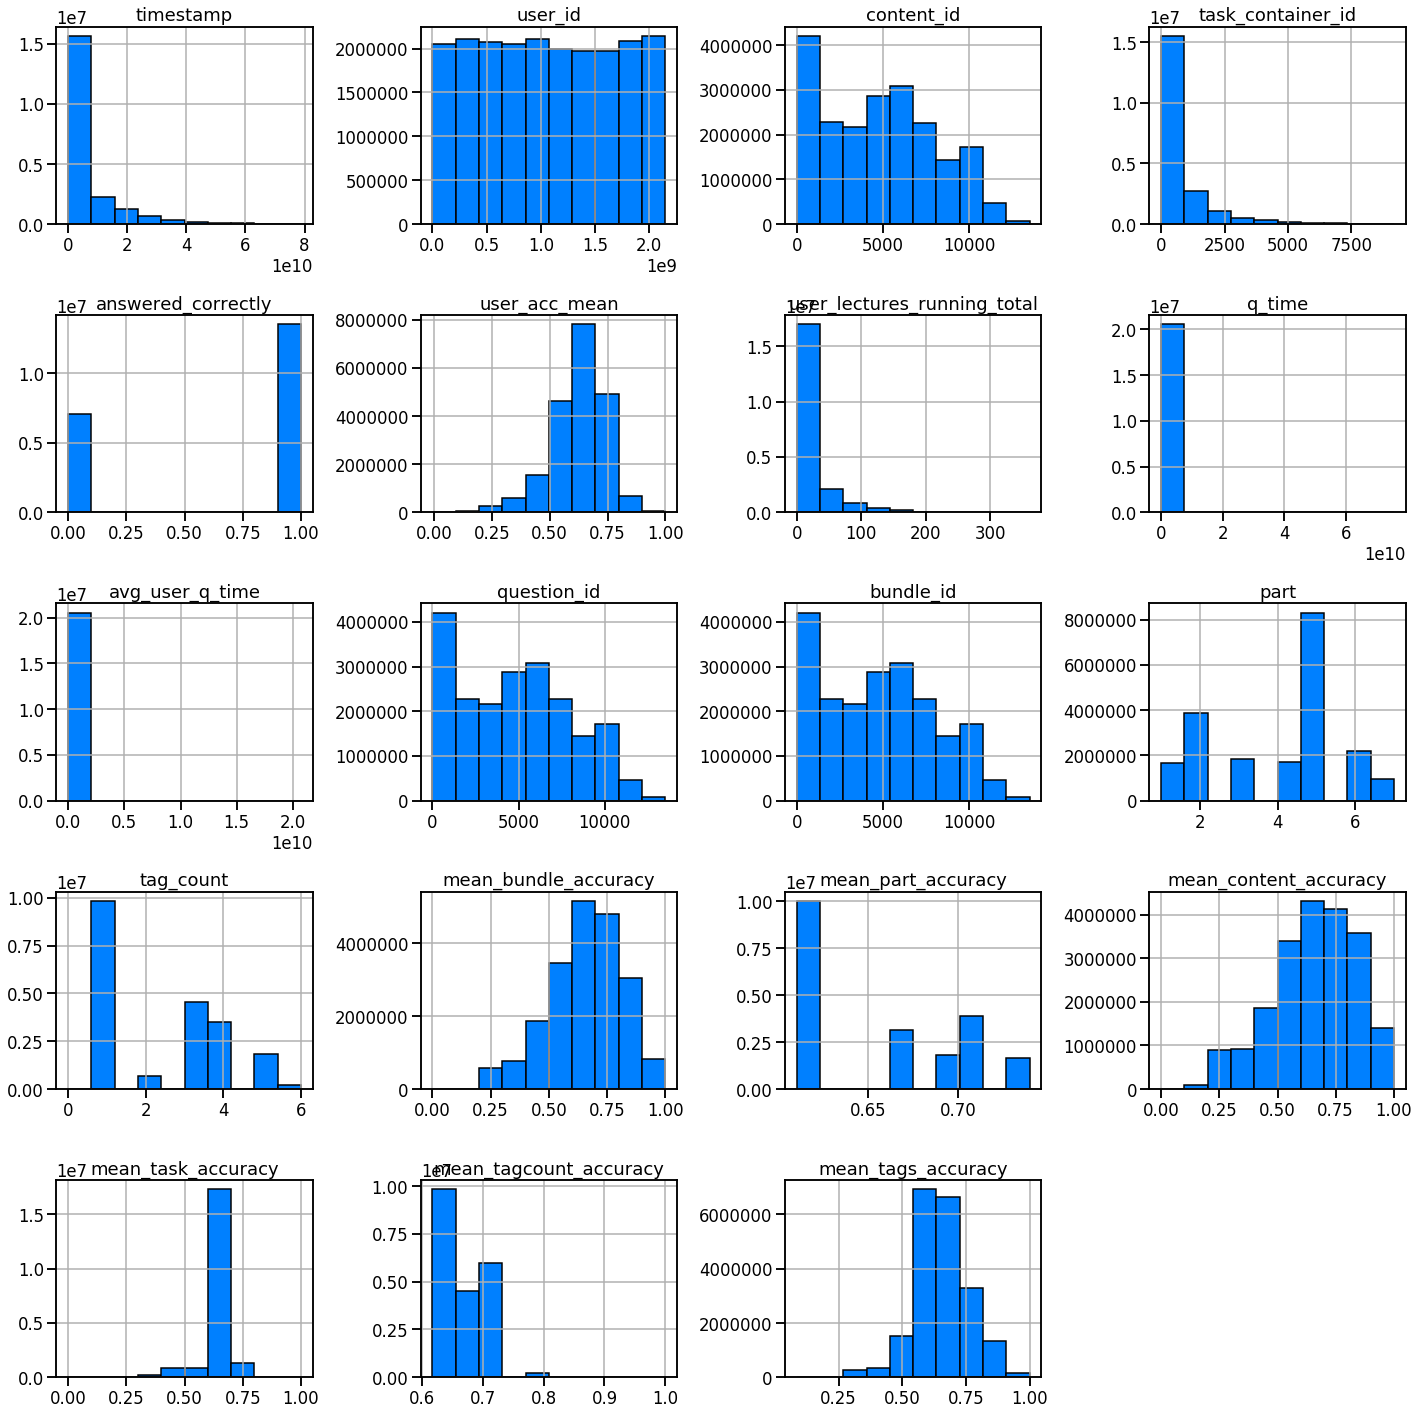

In [15]:
# Plot distributions of features
sns.set_context('talk')

train.hist(figsize=(20, 20),
           grid=True,
           color='#0080ff',
           ec='black')

plt.tight_layout()
plt.show()

- Plotting features to understand how their values are distributed.

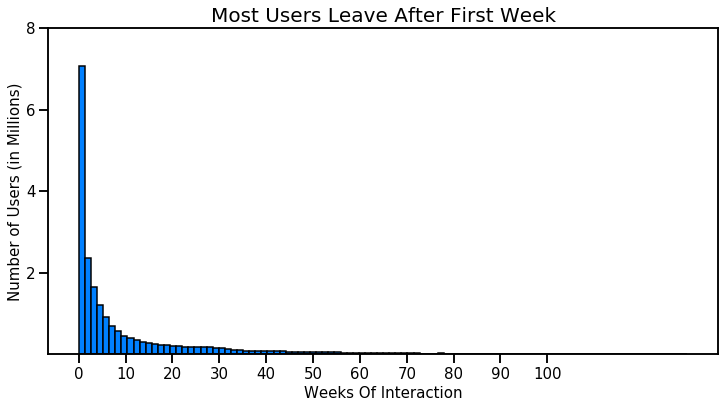

In [16]:
# User_id vs Timestamp
# Had to convert time from in milliseconds to weeks
ts = train['timestamp']/(31536000000/52)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100, color='#0080ff', ec='black') 
plt.title("Most Users Leave After First Week", fontsize=20)
plt.xlabel("Weeks Of Interaction", fontsize=15)
plt.ylabel("Number of Users (in Millions)", fontsize=15)
plt.xticks(np.linspace(0,100,11),rotation=0, fontsize=15)
plt.yticks([2000000,4000000,6000000,8000000],labels=['2','4','6','8'], rotation=0, fontsize=15)
plt.show()

In [17]:
# Create new columns for plotting.
train = train.assign(sections = np.where(train.part > 4, 'Reading', 'Listening'),
                     is_incomplete_sentence_part = np.where(train.part == 5, 'incomplete sentences', 'other'))

train.question_had_explanation = train.question_had_explanation.map({True: 'Yes', False: 'No'})

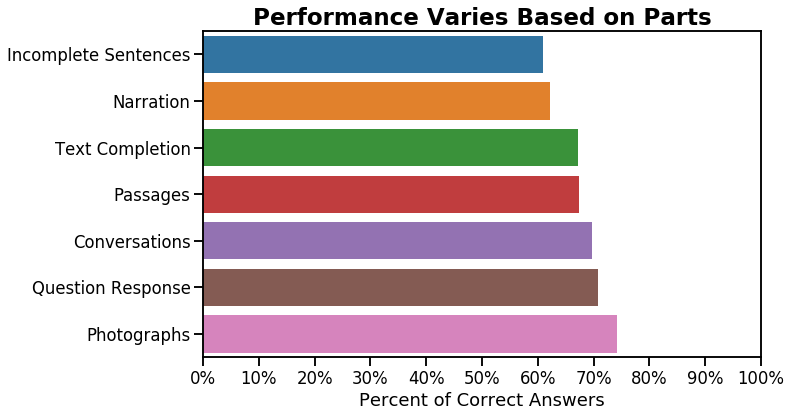

In [18]:
# Create a dataframe to hold the average acuracy for each part. 
part_acc = train.groupby('part').answered_correctly.mean()
part_acc = pd.DataFrame(part_acc).reset_index()
part_acc['Parts'] = ['Photographs',
                     'Question Response',
                     "Conversations", 
                     "Narration",
                     "Incomplete Sentences",
                     "Text Completion",
                     "Passages"]

part_acc = part_acc.sort_values(by='answered_correctly')


sns.set_context('talk')

plt.figure(figsize=(10, 6))
sns.barplot(data=part_acc, x='answered_correctly', y='Parts')
plt.xlabel("Percent of Correct Answers")
plt.ylabel("")
plt.title("Performance Varies Based on Parts", fontweight='bold', fontsize=23)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.xticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

- Students perform best on photographs.
- Students perform the worst on incomplete setences and talks(narration or one-way communication). Incomplete sentence questions test a students verb conjugation. For example. Runs, runnning, ran, run. Talks(Narrations or One-way Commnuication) questions require a student to listen to a short talk then answer 3 questions about the talk. Each talk is spoken only one time.

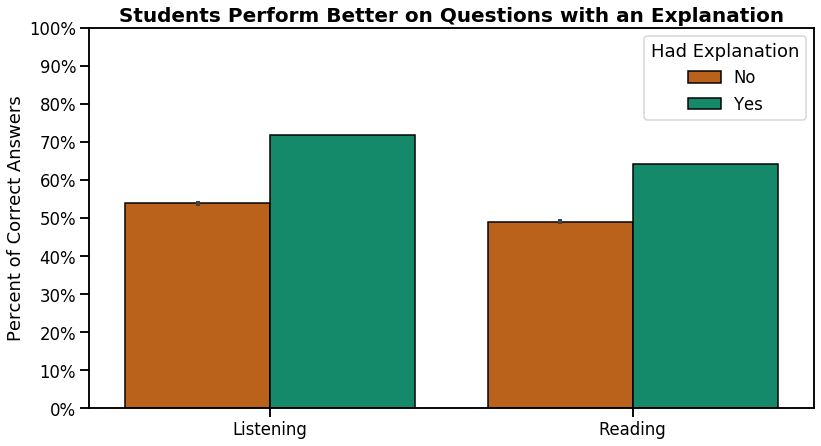

In [19]:
sns.set_context('talk')

plt.figure(figsize=(13,7))
sns.barplot(data=train, x='sections', y='answered_correctly', hue='question_had_explanation',
            palette=['#d55e00', '#009e73'], ec='black')
plt.title("Students Perform Better on Questions with an Explanation", fontweight='bold', fontsize=20)
plt.xlabel("")
plt.ylabel("Percent of Correct Answers")
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)] # Format you want the ticks, e.g. '40%'
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.legend(bbox_to_anchor=(1, 1), title ='Had Explanation')
plt.show()

- Students perform better on questions with an explanation, regardless if it's a Listening question or a reading question.

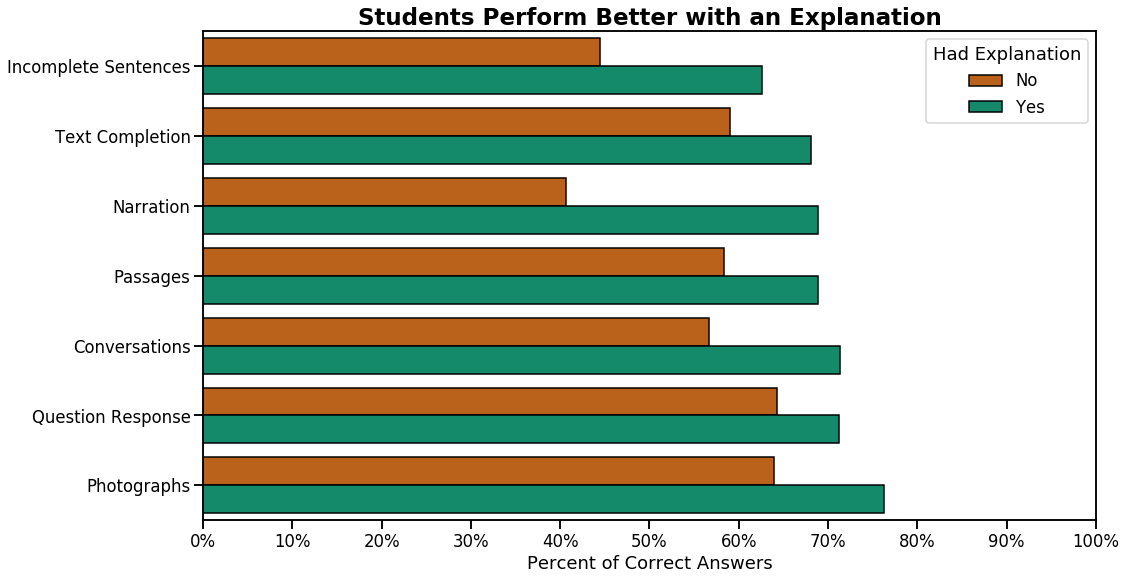

In [20]:
# Plot displays how students perform on questions with and without explanations
explore.question_explanation_graph(train)

- Users perform better on questions with explanations, than questions without explanations. 
    - A possible reason for this could be that the guidance from the explanations are actually helpful. 

In [21]:
# Pick up the top 3 lecture watchers in the train dataset

top3 = explore.top_lectures_watchers(train, 3)
top3.head()

timestamp    user_id content_id task_container_id answered_correctly  \
286900     151007  372519499         98                 6                  1   
286901  336520878  372519499       7942               223                  0   
286902  336553287  372519499        191               224                  1   
286903  336586895  372519499        110               225                  0   
286904  336618895  372519499      10516               226                  1   

       question_had_explanation  user_acc_mean user_lectures_running_total  \
286900                      Yes       0.615349                           0   
286901                      Yes       0.615349                           6   
286902                      Yes       0.615349                           6   
286903                      Yes       0.615349                           6   
286904                      Yes       0.615349                           6   

            q_time  avg_user_q_time  ...           tags tag_count  \
286900  47085520.0        2109080.0  ...  10 178 162 81         4   
286901     32409.0        2109080.0  ...      131 40 38         3   
286902     33608.0        2109080.0  ...     131 40 102         3   
286903     32000.0        2109080.0  ...      131 13 38         3   
286904     32780.0        2109080.0  ...      10 178 92         3   

       mean_bundle_accuracy mean_part_accuracy mean_content_accuracy  \
286900                 0.76               0.74                  0.76   
286901                 0.65               0.74                  0.65   
286902                 0.76               0.74                  0.76   
286903                 0.62               0.74                  0.62   
286904                 0.84               0.74                  0.84   

        mean_task_accuracy  mean_tagcount_accuracy  mean_tags_accuracy  \
286900                0.32                0.702264            0.760110   
286901                0.67                0.675394            0.747356   
286902                0.67                0.675394            0.759684   
286903                0.67                0.675394            0.682667   
286904                0.67                0.675394            0.705343   

         sections  is_incomplete_sentence_part  
286900  Listening                        other  
286901  Listening                        other  
286902  Listening                        other  
286903  Listening                        other  
286904  Listening                        other  

[5 rows x 23 columns]

In [22]:
# Compute the cumulative accuracy for the top 3 lecture watchers
cum_acc = explore.calculate_cum_acc(top3)

# Merge the dataframes top3 and cum_acc
top3 = pd.concat([top3, cum_acc], axis=1)
top3.head(2)

timestamp    user_id content_id task_container_id answered_correctly  \
286900     151007  372519499         98                 6                  1   
286901  336520878  372519499       7942               223                  0   

       question_had_explanation  user_acc_mean user_lectures_running_total  \
286900                      Yes       0.615349                           0   
286901                      Yes       0.615349                           6   

            q_time  avg_user_q_time  ... tag_count mean_bundle_accuracy  \
286900  47085520.0        2109080.0  ...         4                 0.76   
286901     32409.0        2109080.0  ...         3                 0.65   

       mean_part_accuracy mean_content_accuracy mean_task_accuracy  \
286900               0.74                  0.76               0.32   
286901               0.74                  0.65               0.67   

        mean_tagcount_accuracy  mean_tags_accuracy   sections  \
286900                0.702264            0.760110  Listening   
286901                0.675394            0.747356  Listening   

        is_incomplete_sentence_part  cum_accuracy  
286900                        other             1  
286901                        other           0.5  

[2 rows x 24 columns]

In [23]:
# Map the user id to student A-C

top3.user_id = top3.user_id.map({1109748920: 'Student_A',
                                 2066672014: 'Student_B', 
                                 372519499: 'Student_C'})

In [24]:
# RUN THIS CELL WHEN NECESSARY
# Cast the dtypes of user_lectures_running_total and cum_accuracy to float

top3.user_lectures_running_total = top3.user_lectures_running_total.astype('float')
top3.cum_accuracy = top3.cum_accuracy.astype('float')

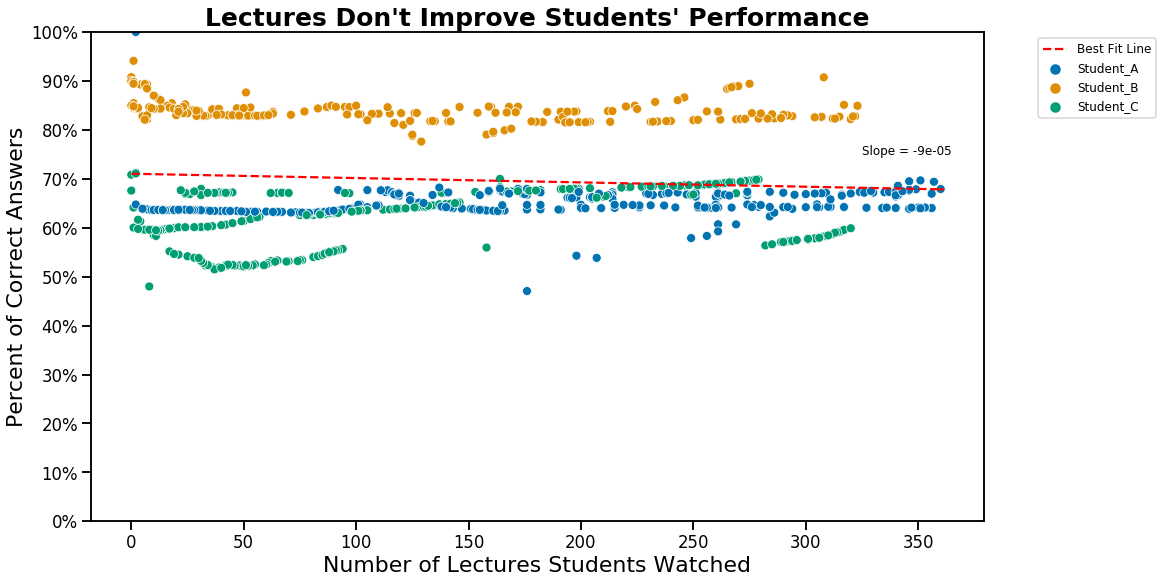

In [25]:
# Plot the cumulative accuracy against the lectures the users has watched for the top 3 lecture watcher
explore.top_lecture_watchers_perform(top3)

In [26]:
# Load the users' cumulative accuracy for the train dataset
train_cumacc = pd.read_csv("train_cumacc.csv", index_col=0)
train_cumacc.head()

cum_accuracy
0      1.000000
1      0.500000
2      0.666667
3      1.000000
4      0.500000

In [27]:
# Concat the cumulative accuracy to the train dataset
train_cumacc = pd.concat([train, train_cumacc], axis=1)

In [28]:
# Compute the cumulative accuracy against the lectures for the whole train dataset

pop_cum_acc = train_cumacc.groupby("user_lectures_running_total").cum_accuracy.mean()
pop_cum_acc = pd.DataFrame(pop_cum_acc).reset_index()
pop_cum_acc.head()

user_lectures_running_total  cum_accuracy
0                            0      0.592448
1                            1      0.641597
2                            2      0.640780
3                            3      0.642574
4                            4      0.646725

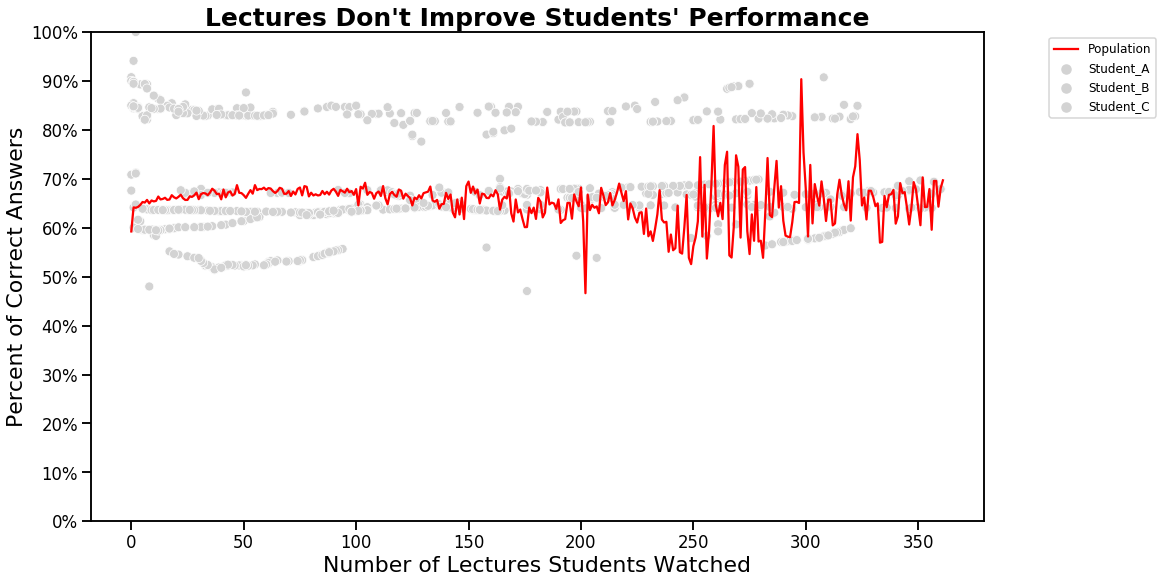

In [29]:
# Plot the cumulative accuracy against the lectures the user has watched
explore.cumacc_on_lectures(top3, pop_cum_acc)

### Add takeaways

# Hypothesis Testing

## Hypothesis Test 1

### General Inquiry
<br>
Does getting a question right depend on it having an explanation?

### Chi-Squared Test

$H_0$: `question_had_explanation` and `answered_correctly` are independent
<br>
$H_a$: `question_had_explanation` and `answered_correctly` are dependant

In [30]:
# Creating crosstab of data reflecting if question was answered correctly 
# and if it had an explanation.
observed_pqhe = pd.crosstab(train.answered_correctly, 
                            train.question_had_explanation)

# Displaying crosstab
observed_pqhe

question_had_explanation       No       Yes
answered_correctly                         
0                         1088346   5957563
1                         1151211  12357398

In [31]:
# Calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(observed_pqhe)

# Printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.0000


- P is less than alpha, so we <b>reject</b> the null hypothesis that answered_correctly and question_had_explanation are independent
---

## Hypothesis Test 2

### General Inquiry
Does getting a question right depend on the part of the exam?

### Chi-Squared Test
$H_0$ Whether a user answers a question correctly is independent of the type of question being asked.<br>
$H_a$ Whether a user answers a question correctly is dependent upon the type of question being asked.

In [32]:
# Contingency table
table = pd.crosstab(train.answered_correctly, train.part)
chi2, p, degf, expected = stats.chi2_contingency(table)

# Printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.0000


- P is less than alpha, so we <strong>reject</strong> the null hypothesis that answering a question correctly is independent of the type of question being asked. (Different parts of the TOEIC exam)
- The 7 parts of the TOEIC exam require the user to answer questions with different formats: Pictures, Listening to Conversations, Reading Conversations, Filling in Incomplete Sentences, etc.
---

## Hypothesis Test 3

### General Inquiry
<br>
Is there a linear relationship between the average time it takes a user to answer a question and their average accuracy?

### Pearson Correlation Test

$H_0$: There is no linear relationship between `avg_user_q_time` and `user_acc_mean`
<br>
$H_a$: There is a linear relationship between `avg_user_q_time` and `user_acc_mean`

In [33]:
# Performing pearson correlation test
r, p = stats.pearsonr(train.avg_user_q_time, train.user_acc_mean)

# Displaying alpha and test results
print("alpha = .05\n")
print("r correlation coefficient", np.round(r, 4))
print("p value                   ", np.round(p, 4))

alpha = .05

r correlation coefficient -0.0799
p value                    0.0


- P is less than alpha, so we <b>reject</b> the null hypothesis that there is no linear relationship between the variables.
- Given the r correlation coefficient of -.08, we see almost no relationship between the variables.
- Although the relationship between these variables is weak, it was still worth exploring because to needed to see the correlation between these variables.
---

## Hypothesis Test 4

### General Inquiry
<br>
Do users with high accuracy take less time to answer difficult questions than other users?

### Two-Sample Two-Tailed T-Test
$H_0$: The avg time that users with above avg accuracy spend on questions with below avg content accuracy is equal to or greater than the avg time that users with avg or below accuracy spend on them.
<br><br>
$H_a$: The avg time that users with above avg accuracy spend on questions with below avg content accuracy is less than the avg time that users with avg or below accuracy spend on them.

In [34]:
# Creating df of all questions that had less than average mean_content_accuracy
# ie. all questions that users answered incorrectly more often than average
hard_questions = train[train.mean_content_accuracy < train.mean_content_accuracy.mean()]

# Filtering DF above for all users with above avg accuracy
hi_acc_users = hard_questions[hard_questions.user_acc_mean > hard_questions.user_acc_mean.mean()]

# Filtering DF above for all users with avg or below accuracy
low_acc_users = hard_questions[hard_questions.user_acc_mean <= hard_questions.user_acc_mean.mean()]

In [35]:
# Performing two sample, two tailed t-test
t, p = stats.ttest_ind(hi_acc_users.q_time, low_acc_users.q_time, equal_var = False)

# Printing results
print('alpha = .05\n')
print("test statistic   ", np.round(t, 4))
print("p value           ", np.round(p, 4))

alpha = .05

test statistic    -35.7593
p value            0.0


- P is less than alpha, so we <b>reject</b> the null hypothesis. 
- The sub-alpha p-value and negative test statistic indicate that users with higher accuracy spend less time on difficult questions than others. 
    - The explanation for this might be that many high accuracy users are well prepared for difficult questions than users with lower accuracy. and not that they are spending more time on hard questions to improve their performance.
---

## Hypothesis Test 5

### General Hypothesis
<br>
Is there a linear relationship between the number of lectures a user has viewed and their task performance? Task performance measures a user's accuracy on a specific bundle of questions. A bundle can contain one or more questions.

### Pearson Correlation Test

$H$0: There is no linear relationship between `user_lectures_running_total` and `mean_task_accuracy`
<br>
$H$a: There is a linear relationship between `user_lectures_running_total` and `mean_task_accuracy`

In [36]:
# performing pearson correlation test
r, p = stats.pearsonr(train.user_lectures_running_total, train.mean_task_accuracy)

# printing alpha and results
print("alpha = .05\n")
print("r correlation coefficient", np.round(r, 2))
print("p value                  ", np.round(p, 4))

alpha = .05

r correlation coefficient 0.37
p value                   0.0


- Since p is less than alpha, we <b>reject</b> the null hypothesis that there is no linear relationship between `mean_task_accuracy` and `user_lectures_running_total`.    

- The r correlation coefficient of .37 indicates that there is a weak linear relationship between these variables.
    - As the number of lectures that a user has seen increases, so does their task accuracy on average.
    - Viewing lectures has a positive, albeit weak, impact on user performance.
---

## Feature Selection
### Separate the features from the target variable

In [37]:
# Split train, validate, and test into X_set and y_sets
X_train = train_s.drop(columns='answered_correctly')
y_train = train_s['answered_correctly']

X_validate = validate_s.drop(columns='answered_correctly')
y_validate = validate_s['answered_correctly']

X_test = test_s.drop(columns='answered_correctly')
y_test = test_s['answered_correctly']

In [38]:
# Display the first 3 rows of X_train
X_train.head(3)

question_had_explanation  user_acc_mean  mean_bundle_accuracy  \
0                         0          0.275                  0.82   
1                         0          0.275                  0.41   
2                         0          0.275                  0.36   

   mean_part_accuracy  mean_content_accuracy  mean_task_accuracy  \
0                0.74                   0.82                0.68   
1                0.74                   0.41                0.53   
2                0.74                   0.36                0.44   

   mean_tagcount_accuracy  mean_tags_accuracy  \
0                0.675394            0.777457   
1                0.675394            0.492395   
2                0.675394            0.524273   

   user_lectures_running_total_scaled  avg_user_q_time_scaled  
0                                 0.0                0.000003  
1                                 0.0                0.000003  
2                                 0.0                0.000003

In [39]:
# Display the first 3 values y_train
y_train.head(3)

0    1
1    0
2    1
Name: answered_correctly, dtype: int8

## Select Top 5 Features by Select K Best

In [40]:
# Compute the top 5 features using SelectKBest
f_features = explore.KBest_ranker(X_train, y_train, 5)

# Display the top 5 features
f_features

features       score  rank
0  mean_content_accuracy  3287990.94     1
1   mean_bundle_accuracy  2456676.20     2
2          user_acc_mean  1197142.13     3
3     mean_tags_accuracy  1105464.70     4
4     mean_task_accuracy   390216.48     5

## Select Top 5 Features by Recursive Feature Elimination (RFE)

In [41]:
# Using function from explore.py to rank using RFE
rfe_ranker(X_train, y_train)

feature  rank
0               mean_content_accuracy     1
1                       user_acc_mean     2
2                  mean_task_accuracy     3
3                mean_bundle_accuracy     4
4  user_lectures_running_total_scaled     5

## Explore Takeaways
### Graphs:
- Most users leave after the first week.
- Of all questions asked, users tend to answer most of them correctly.
- Questions that have explanations are more likely to be answered correctly.
- Answering more questions leads to slightly higher accuracy.
    
### Hypothesis Testing:
|  | Statistical Test | Result |
| :----  | :--------------- | :-------|
| <b>Hypothesis 1</b> |  Chi-squared | A question with an explanation and the question being answered correctly is dependent. |
| <b>Hypothesis 2</b> | Chi-squared | Getting a question right is dependent on the part of the exam. |
| <b>Hypothesis 3</b> | Pearson's Correlation |  An inverse linear relationship exists between the average time users spend on a question and their average accuracy.  |
| <b>Hypothesis 4</b> | Two-sample One-tailed T-Test | High accuracy users spend less time on hard questions than other users with lower accuracy. |
| <b>Hypothesis 5</b> | Pearson's Correlation | A linear relationship exists between average task accuracy and the number of lectures a user has viewed.|

### Feature Selection:
The top 3 features shared between __Select K Best__ and __RFE__ rankers were:
- `user_acc_mean`
- `mean_content_accuracy`
- `mean_bundle_accuracy`

# 4. Modeling<a id='modeling'></a>
Establish a baseline and create several classification models that predict whether a student answers a question correctly.<br>

[Return to Top](#toc)
***

## Compute the baseline AUC score

### Use the randomly generated classes as the baseline

In [42]:
# Compute the size of y_train
size = y_train.size

# Construct y_baseline
y_baseline_random = np.random.randint(2, size=size)

# Print the y_baseline
y_baseline_random

array([0, 1, 0, ..., 1, 1, 1])

In [43]:
# Compute the AUC score 
roc_auc_score(y_train, y_baseline_random)

0.4999287650043248

### Use the most frequent class as the baseline

In [44]:
# Compute the most frequent class
y_train.value_counts(normalize=True)

1    0.657209
0    0.342791
Name: answered_correctly, dtype: float64

In [45]:
# Construct the y_baseline_frequency
y_baseline_frequency = np.array([1]*size)

# Check the baseline values
y_baseline_frequency

array([1, 1, 1, ..., 1, 1, 1])

In [46]:
# Compute the AUC score 
roc_auc_score(y_train, y_baseline_frequency)

0.5

**Baseline Results**<br>
The baseline AUC score is 0.5, regardless of the method used.

## Build Classification Models

### Train

In [47]:
# Create a list of names of the classifiers
names = ['Logistic Regression', # predict_proba: yes
         'Random Forest', # predict_proba: yes
         'Gradient Boost', # predict_proba: yes
        ]


# Create a list of classifiers
classifiers = [LogisticRegression(),
               RandomForestClassifier(max_depth=3),
               GradientBoostingClassifier(),
              ]


train_metrics, models = train_model(names, classifiers, X_train, y_train)

# Rank auc score on train
train_metrics

Currently running on model Logistic Regression
Currently running on model Random Forest
Currently running on model Gradient Boost


AUC score                 Algo dataset
0   0.754796       Gradient Boost   train
1   0.752522  Logistic Regression   train
2   0.732175        Random Forest   train

In [48]:
################### Build LightGBM Model #########################

# Create versions of train, validate, and test for lgbm
train_data = lgb.Dataset(X_train, label=y_train)
validate_data = lgb.Dataset(X_validate, label=y_validate)
test_data = lgb.Dataset(X_test, label=y_test)

# Create a list of parameters
params = {'boosting_type': ['gbdt'],
          'objective': ['binary'],
          'nthread': [-1],
          'num_class' :[1],
          'metric' : ['auc'],
          'seed' : [369]}

# Create classifier to use
mdl = lgb.train(params,
                train_data,
                valid_sets=validate_data,
                verbose_eval=5_000,
                num_boost_round=10_000,
                early_stopping_rounds=10)

[LightGBM] [Info] Number of positive: 13508609, number of negative: 7045910
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 20554519, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657209 -> initscore=0.650880
[LightGBM] [Info] Start training from score 0.650880
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.744517


In [49]:
# Feature Importance
sns.set_context('poster')

lgb.plot_importance(mdl,
                    max_num_features=5,
                    figsize=(12, 8),
                    grid=False,
                    dpi=1000)

plt.grid(axis='x')
plt.title('Feature Importance')
plt.xlabel('')
plt.ylabel('')
plt.yticks(np.arange(0, 6), ['Time Spent on Question',
                             'Problem Set Difficulty',
                             'Number of Lectures Viewed',
                             'Question Difficulty',
                             'Individual Performance']);

### Validate

In [50]:
validate_metrics = validate_model(names, models, X_validate, y_validate)
validate_metrics

Currently running on model Logistic Regression
Currently running on model Random Forest
Currently running on model Gradient Boost


AUC score                 Algo   dataset
0   0.744036       Gradient Boost  validate
1   0.742949  Logistic Regression  validate
2   0.723421        Random Forest  validate

In [51]:
# Fit light gradient boost model with train set
# Evaulate AUC Score using the validation set
lgbm = lgb.train(params,
                 train_data,
                 valid_sets=validate_data,
                 verbose_eval=5_000,
                 num_boost_round=10_000,
                 early_stopping_rounds=10,
                 )

[LightGBM] [Info] Number of positive: 13508609, number of negative: 7045910
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 20554519, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657209 -> initscore=0.650880
[LightGBM] [Info] Start training from score 0.650880
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.744517


### Test

In [52]:
X_train = train_s[['mean_content_accuracy', 'user_acc_mean']]
X_validate = validate_s[['mean_content_accuracy', 'user_acc_mean']]
X_test = test_s[['mean_content_accuracy', 'user_acc_mean']]

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

lgbm = lgb.train(params,
                 train_data,
                 valid_sets=test_data,
                 verbose_eval=100,
                 num_boost_round=10_000,
                 early_stopping_rounds=10,
                 )


# Predict on test set
predictions_lgbm_prob = lgbm.predict(X_test)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

[LightGBM] [Info] Number of positive: 13508609, number of negative: 7045910
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 20554519, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657209 -> initscore=0.650880
[LightGBM] [Info] Start training from score 0.650880
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.740408


In [53]:
predictions_lgbm_prob

array([0.37451368, 0.48520629, 0.32022817, ..., 0.92985985, 0.78902938,
       0.70115858])

In [54]:
lgb.plot_tree(lgbm, figsize=(26,26),
              dpi=1000,
              tree_index=1,
              show_info ='data_percentage');

<Figure size 432x288 with 0 Axes>

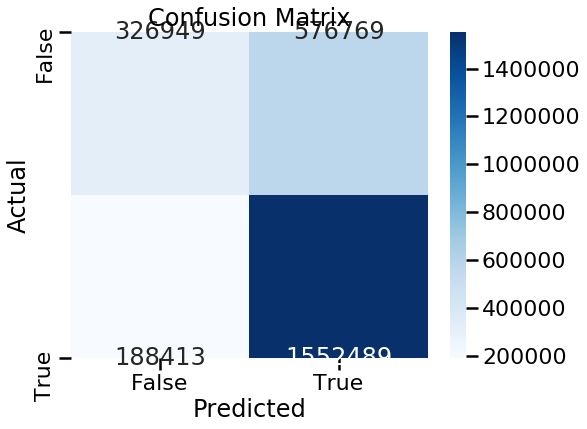

In [55]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, predictions_lgbm_01)
labels = ['False', 'True']
plt.figure(figsize=(8,6))

sns.heatmap(cm,
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt='d');

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Modeling Results**
- Light Gradient Boost Machine produces the highest AUC score on the test dataset.
- The AUC score from the top model is 0.74.
- The AUC score for the baseline is 0.500.
- The top model surpassed the baseline by 0.24, a 47% improvement
     - Calculated using difference between the our model's AUC score minus the baseline AUC score, divided by the baseline AUC score.

### Plot the ROC curve of the top model

In [56]:
response = pd.Series(np.where(y_test == 1, 'Correct Answer', 'Incorrect Answer'))
probas = pd.concat([pd.Series(predictions_lgbm_prob), response],
                          axis=1)

probas.columns = ['proba', 'label']

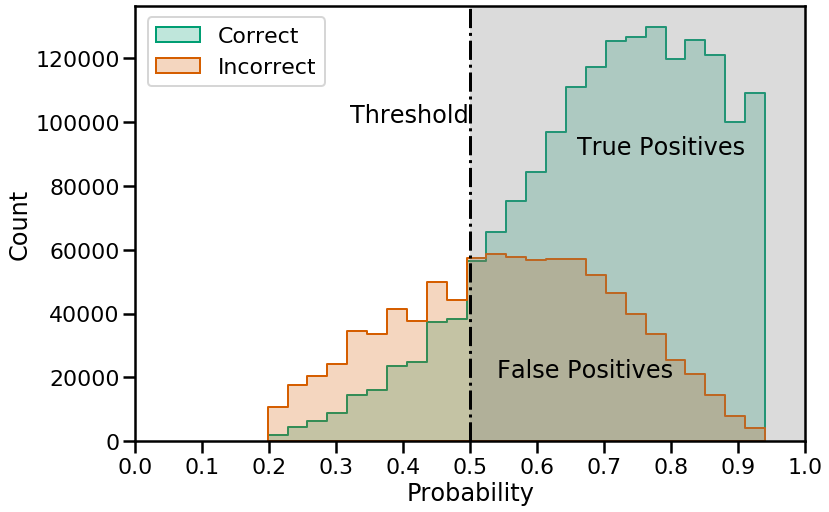

In [57]:
sns.set_context('poster')

plt.figure(figsize=(12, 8))
sns.histplot(data=probas,
             x='proba',
             hue='label',
             element='step',
             fill=True,
             bins=25,
             palette=['#d55e00', '#009e73'])

plt.xlabel('Probability')
plt.xlim(0, 1)
plt.xticks(np.linspace(0, 1, 11))
plt.legend(bbox_to_anchor=(.3, 1), labels=['Correct', 'Incorrect'])

plt.axvline(.5, 0, 128_000, label='threshold', color='black', linestyle='-.')
plt.axvspan(0.5, 1, facecolor='grey', alpha=0.28)
plt.text(0.32, 100_000, 'Threshold', rotation=0)
plt.text(0.54, 20_000, 'False Positives', rotation=0)
plt.text(0.66, 90_000, 'True Positives', rotation=0)

plt.show()

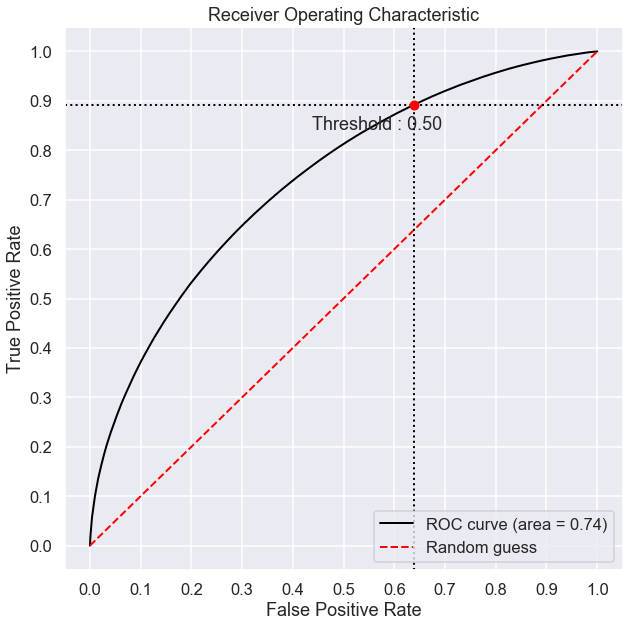

In [58]:
# Visualisation with plot_metric
sns.set_context('talk')
plt.figure(figsize=(10,10))

bc = BinaryClassification(y_test,
                          predictions_lgbm_prob,
                          labels=['Actual', 'Predicted'],
                          threshold=.5)

bc.plot_roc_curve()
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.show()

### Modeling Takeaways
- <b>Baseline:</b> 0.5 AUC Score  


- <b>Top model: (result from the test set)</b> 
    - Light Gradient Boost Machine 0.74 AUC Score   
    
    

- <b>Features used on all models:</b>
    - mean_content_accuracy
    - user_acc_mean
    - mean_task_accuracy
    - question_had_explanation
    - user_lectures_running_total
    - avg_user_q_time


- <b>Features used on Light Gradient Boost Machine:</b>
    - user_acc_mean
    - mean_content_accuracy

# 5. Conclusions<a id='conclusions'></a>
### Summary of key takeaways, results, and next steps<br>

[Return to Top](#toc)
***

### Acquire
- Data initially acquired from Kaggle and saved as local files: lectures.csv, questions.csv, and train.csv.
- Merged the csv files into a single dataset.

### Prepare
- Filled missing values with appropriate values varying according to the column.
- Dropped columns that were not needed. 
- Dropped rows that represent lectures.
- Converted True and False values to 1's and 0's, respectively.
- Created scaled versions of the train, validate, and test sets.
- Added engineered features to the train, validate, and test sets.

### Explore

__Graphs__
- Most users leave after the first week.
<br>
- The majority of the questions asked are answered right.
<br>
- Questions that have explanations are more likely to be answered correctly.
<br>
- Answering more questions leads to slighty higher accuracy for students.

__Hypothesis Testing__

|  | Statistical Test | Result |
| :----  | :--------------- | :-------|
| <b>Hypothesis 1</b> |  Chi-squared | A question with an explanation and the question being answered correctly is dependent. |
| <b>Hypothesis 2</b> | Chi-squared | Getting a question right is dependent on the part of the exam. |
| <b>Hypothesis 3</b> | Pearson's Correlation |  An inverse linear relationship exists between the average time users spend on a question and their average accuracy.  |
| <b>Hypothesis 4</b> | Two-sample One-tailed T-Test | High accuracy users spend less time on hard questions than other users with lower accuracy. |
| <b>Hypothesis 5</b> | Pearson's Correlation | A linear relationship exists between average task accuracy and the number of lectures a user has viewed.|

__Feature Selection__
The top 3 features that Select K Best and RFE rankers found in common were:
- mean_content_accuracy
- user_acc_mean
- mean_bundle_accuracy

### Modeling

__Overall__ 
- The highest AUC score on the test dataset is produced by Light Gradient Boost Machine.
- The top model surpassed the baseline by 0.24, which is a 47% improvement (which is a comparison of the difference between the scores divided by the baseline).

__Recommendations__
- Riiid should provide more questions with explanations for students. 
- Focus on improving user engagement after the first week to increase user retention. 
- Using our project, Riiid can assess: 
    - ... question difficulty level based on population performance (mean_content_accuracy and mean_task_accuracy).
    - ... an individual's performance based on their average performance (user_acc_mean). 
    - ... how time spent on a question impacts a student's accuracy (avg_user_q_time_scaled). 

- Using our model, Riiid can predict the future performance of current students. 

__Expectations__
- Providing more explanations could improve overall answer accuracy. 
- Increasing user retention would give a better representation of student long-term performance. 


### Future Investigations
- Use this predictive model on Riiid's other educational programs. 
- Explore more features and different classification models like xgboost and lightlgbm.
- Improve model by to predict new student performance. 